# EDA Exploratoria Orientada a Señales Predictivas

**Proyecto:** Fantasy Bidding Intelligence  
**Notebook:** 02_eda_exploratoria.ipynb  
**Objetivo:** Analizar las variables del dataset desde una perspectiva predictiva, identificando señales relevantes para los problemas de clasificación y regresión antes del modelado.  

---

## 1. Contexto y Alcance

Este notebook se centra en un Análisis Exploratorio de Datos (EDA) orientado a la predicción, y no en la validación de calidad del dataset, ya abordada en el notebook de auditoría previo.

El objetivo principal es:
- Identificar variables con señal predictiva.
- Detectar relaciones relevantes entre features y los targets.
- Formular hipótesis que guíen la fase de feature engineering y modelado.

No se realiza en este punto:
- Limpieza avanzada de datos.
- Transformaciones finales.
- Entrenamiento de modelos.

---


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.set_option("display.max_columns", None)

df = pd.read_csv("../data/processed/data_model.csv")


## 2. Definición de los Problemas Predictivos

A partir del dataset se plantean dos problemas diferenciados:

### 2.1 Problema de Clasificación
**Objetivo:** Predecir si un jugador recibirá alguna puja durante su estancia en el mercado.

- Variable objetivo: `recibe_puja`
- Tipo: Clasificación binaria
- Interpretación:
  - 1 → El jugador es comprado por algún manager.
  - 0 → El jugador no recibe ninguna puja.



In [60]:
df["recibe_puja"] = df["equipo"].notnull().astype(int)

### 2.2 Problema de Regresión
**Objetivo:** Estimar el precio final de compra del jugador, condicionado a que haya recibido alguna puja.

- Variable objetivo: `ganancias`
- Tipo: Regresión
- Condición: Solo se consideran jugadores con `recibe_puja = 1`.

Ambos problemas se analizarán de forma separada para evitar sesgos y leakage de información.

---

In [61]:
df_reg = df[df["recibe_puja"] == 1].copy()
target_reg = "ganancias"


## 3. Análisis del Desbalanceo del Target (Clasificación)

Antes de analizar variables predictoras, se estudia la distribución del target de clasificación para entender el grado de desbalanceo del problema.

Este análisis permite:
- Establecer baselines razonables.
- Definir métricas adecuadas para la evaluación futura de modelos.
- Anticipar la necesidad de técnicas de balanceo.

---

In [62]:
df["recibe_puja"].value_counts(normalize=True)


recibe_puja
0    0.776316
1    0.223684
Name: proportion, dtype: float64

## 4. EDA Univariante Condicionado al Target

En esta sección se analizan variables individuales en relación con el target de clasificación (`recibe_puja`).

El objetivo es observar:
- Diferencias de distribución entre jugadores comprados y no comprados.
- Posibles umbrales o patrones no lineales.
- Variables con separación clara entre clases.

Las variables numéricas analizadas incluyen, entre otras:
- Precio del jugador (`precio`)
- Media de puntos (`avgPoints`)
- Puntos acumulados (`puntosJugador`)
- Variación de precio (`variacion`)
- Jornada en curso (`jornada`)
- Días restantes hasta la siguiente jornada (`detalles`)

---


In [63]:
df.groupby("recibe_puja")["precio"].describe()

,count,mean,std,min,25%,50%,75%,max
recibe_puja,,,,,,,,
0,236.0,2.405886,3.295772,0.16,0.17075,0.5155,3.78900,12.712
1,68.0,4.973426,4.161890,0.16,0.74325,5.1045,7.38975,15.391


### Validación de la hipótesis: Precio inicial

Se observa una diferencia significativa en el precio inicial entre jugadores comprados y no comprados.
Aunque hay solapamiento en precios muy bajos, los jugadores con precios mayores presentan claramente más probabilidad de recibir pujas.
Se recomienda mantener `precio` como feature principal y evaluar transformaciones logarítmicas o discretización en bins para mejorar el rendimiento del modelo.


In [64]:
df.groupby("recibe_puja")["avgPoints"].describe()

,count,mean,std,min,25%,50%,75%,max
recibe_puja,,,,,,,,
0,236.0,2.840678,1.574814,-2.0,2.000,2.9,3.7,14.0
1,68.0,3.744118,1.486394,0.0,2.775,3.8,4.7,7.1


### Validación de la hipótesis: avgPoints

Se observa una diferencia clara en la media y mediana de `avgPoints` entre jugadores comprados y no comprados.
Aunque existe solapamiento entre distribuciones, la variable muestra señal consistente y se considera relevante para el modelado.
Se recomienda evaluar transformaciones o binning para mejorar la capacidad predictiva.

In [65]:
df.groupby("recibe_puja")["puntosJugador"].describe()

,count,mean,std,min,25%,50%,75%,max
recibe_puja,,,,,,,,
0,236.0,24.101695,18.674315,-6.0,9.75,22.0,34.0,77.0
1,68.0,33.220588,18.438964,0.0,19.00,32.5,48.0,69.0


### Validación de la hipótesis: puntosJugador

Los jugadores que reciben pujas presentan media y mediana de puntos totales significativamente mayores que los no comprados.
Aunque hay solapamiento, la variable muestra señal consistente y se considera relevante para el modelado.
Se recomienda evaluar transformaciones o discretización para mejorar la capacidad predictiva.


In [66]:
df.groupby("recibe_puja")["variacion"].describe()

,count,mean,std,min,25%,50%,75%,max
recibe_puja,,,,,,,,
0,206.0,-0.029675,0.052143,-0.211,-0.0560,-0.027,0.005,0.109
1,63.0,0.059635,0.054933,-0.077,0.0235,0.049,0.095,0.171


### Validación de la hipótesis: variacion

Se observa que los jugadores que reciben pujas presentan una variación media positiva, mientras que los no comprados tienden a disminuir de precio.
Esta variable muestra señal clara y consistente para la predicción, y se recomienda incluirla en el modelo con posibles transformaciones o discretización.


In [67]:
df.groupby("recibe_puja")["detalles"].describe()

,count,mean,std,min,25%,50%,75%,max
recibe_puja,,,,,,,,
0,236.0,6.133475,3.578628,0.5,3.0,6.0,9.00,13.0
1,68.0,4.536765,3.909724,0.5,1.0,3.0,7.25,13.0


### Validación de la hipótesis: detalles

Se observa que los jugadores comprados tienden a estar más cerca de la siguiente jornada que los no comprados.
Aunque hay solapamiento, la variable refleja una señal temporal consistente y se recomienda incluirla en el modelo, considerando transformaciones o discretización para mejorar su poder predictivo.



## 5. Variables Categóricas y Probabilidad de Compra

Se analiza la relación entre variables categóricas y la probabilidad de que un jugador reciba pujas.

El análisis se centra en:
- Posición del jugador (`posicionJugador`)
- Estado físico (`estado`)
- Equipo de la liga (`equipoLiga`)
- Jornada de mercado (`jornada`)

Este análisis permite detectar:
- Sesgos estructurales del mercado.
- Preferencias claras por tipo de jugador.
- Variables categóricas con alta capacidad discriminativa.

---


In [68]:
pd.crosstab(df["posicionJugador"], df["recibe_puja"], normalize="index")


recibe_puja,0,1
posicionJugador,,
1.0,0.852941,0.147059
2.0,0.761468,0.238532
3.0,0.729730,0.270270
4.0,0.860000,0.140000


### Validación de la hipótesis: posicionJugador

Se observa que la probabilidad de recibir pujas varía significativamente según la posición del jugador.
La posición 3 presenta la mayor proporción de jugadores comprados (27%), mientras que la posición 4 tiene la menor (14%).
Esto confirma que `posicionJugador` aporta señal predictiva y debe incluirse en el modelo, considerando estrategias de encoding adecuadas.


In [69]:
pd.crosstab(df["estado"], df["recibe_puja"], normalize="index")

recibe_puja,0,1
estado,,
0,0.763359,0.236641
1,1.000000,0.000000
2,0.000000,1.000000
3,0.750000,0.250000
4,1.000000,0.000000
5,0.000000,1.000000


### Validación de la hipótesis: estado (tratamiento prudente)

Se observa que la probabilidad de recibir pujas varía según el estado del jugador.
Algunas categorías presentan mayor o menor propensión a recibir pujas, aunque el número de observaciones es limitado.
Por ello, se recomienda incluir `estado` como feature categórica, utilizando un encoding que capture la señal sin asumir determinismo absoluto.


In [70]:
pd.crosstab(df["equipoLiga"], df["recibe_puja"], normalize="index")


recibe_puja,0,1
equipoLiga,,
1.0,0.785714,0.214286
2.0,0.500000,0.500000
3.0,0.777778,0.222222
4.0,0.615385,0.384615
5.0,0.916667,0.083333
8.0,1.000000,0.000000
9.0,0.590909,0.409091
12.0,0.800000,0.200000
14.0,0.666667,0.333333


### Validación de la hipótesis: equipoLiga

Se observa que la probabilidad de recibir pujas varía según el equipo del jugador.
Algunos equipos tienen mayor proporción de jugadores comprados, mientras que otros presentan muy pocas compras. 
Dado que varias categorías son poco frecuentes, se recomienda incluir `equipoLiga` como feature utilizando un encoding prudente (target encoding o agrupación de categorías raras) para capturar la señal sin riesgo de sobreajuste.


In [71]:
pd.crosstab(df["jornada"], df["recibe_puja"], normalize="index")


recibe_puja,0,1
jornada,,
11,0.675000,0.325000
12,0.670588,0.329412
13,0.825758,0.174242
18,0.914894,0.085106



## 6. EDA Específico para el Problema de Regresión

Este análisis se realiza únicamente sobre jugadores que han sido comprados.

El objetivo es estudiar:
- La relación entre variables numéricas y el precio final de compra.
- Posibles relaciones no lineales.
- Saturación de precios en rangos altos.
- Heterocedasticidad y dispersión de los datos.

Se analizan especialmente variables como:
- Precio inicial (`precio`)
- Media de puntos (`avgPoints`)
- Puntos acumulados (`puntosJugador`)
- Número de pujas no ganadas (`num_pujas`)

---


<Axes: xlabel='precio', ylabel='ganancias'>

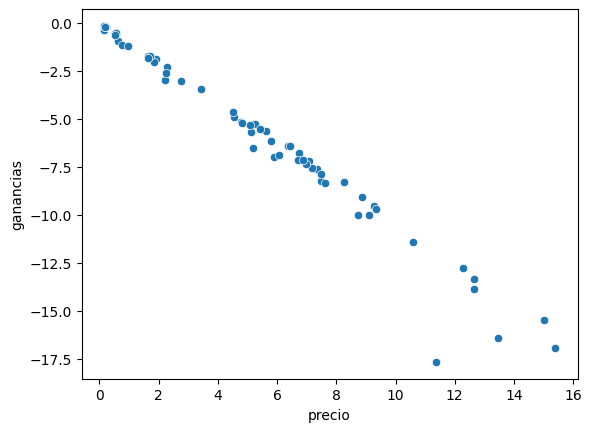

In [72]:
sns.scatterplot(x="precio", y="ganancias", data=df_reg)


<Axes: xlabel='avgPoints', ylabel='ganancias'>

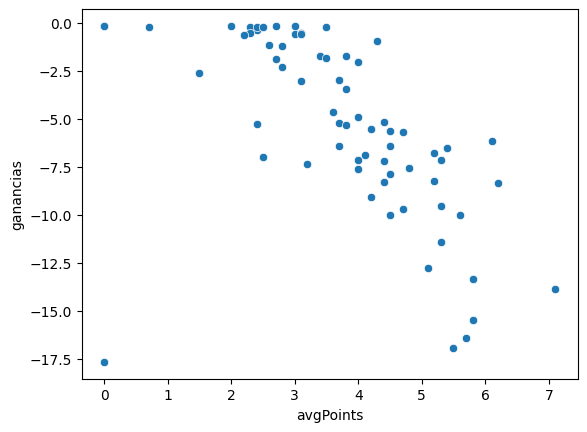

In [73]:
sns.scatterplot(x="avgPoints", y="ganancias", data=df_reg)


<Axes: xlabel='puntosJugador', ylabel='ganancias'>

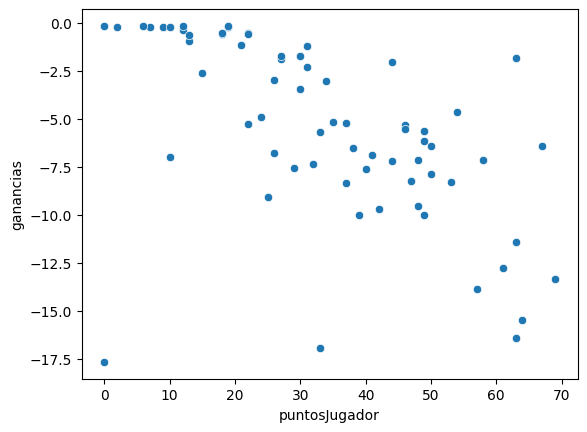

In [74]:
sns.scatterplot(x="puntosJugador", y="ganancias", data=df_reg)


<Axes: xlabel='num_pujas', ylabel='ganancias'>

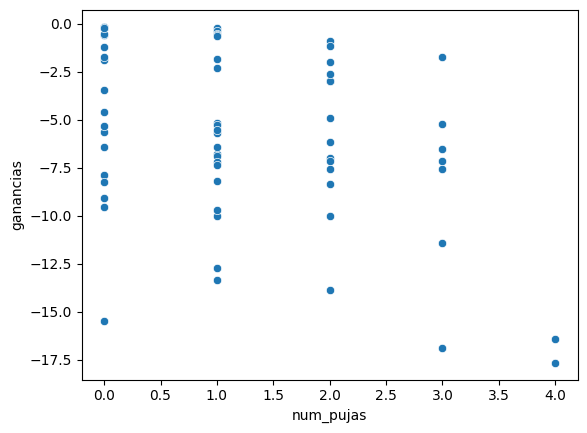

In [75]:
sns.scatterplot(x="num_pujas", y="ganancias", data=df_reg)


## 7. Análisis de Correlaciones y Redundancia

Se estudian correlaciones entre variables numéricas relevantes para:
- Identificar posibles redundancias.
- Detectar variables altamente correlacionadas.
- Anticipar problemas de multicolinealidad en modelos lineales.

Este análisis se utiliza como apoyo a la fase de selección y transformación de features, no como criterio único de descarte.

---


                 precio  avgPoints  puntosJugador  ganancias
precio         1.000000   0.669668       0.662423  -0.986875
avgPoints      0.669668   1.000000       0.769010  -0.603868
puntosJugador  0.662423   0.769010       1.000000  -0.596410
ganancias     -0.986875  -0.603868      -0.596410   1.000000


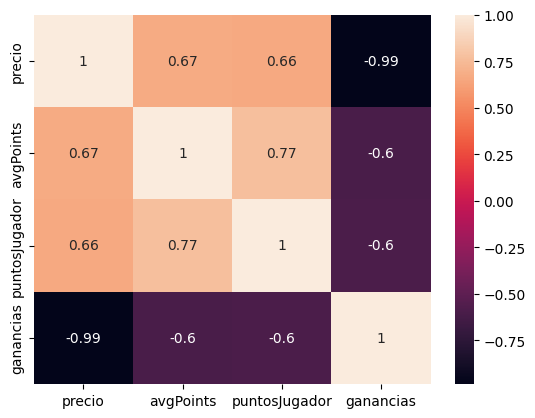

In [76]:
corr = df_reg[["precio","avgPoints","puntosJugador","ganancias"]].corr()
sns.heatmap(corr, annot=True)
print(corr)

### Análisis de correlación entre features numéricas

- `precio` y `ganancias` presentan correlación negativa extremadamente alta (-0.987), indicando redundancia casi determinística. Se recomienda evaluar si mantener ambas o crear feature derivada.
- `avgPoints` y `puntosJugador` están altamente correlacionadas (0.769), pero no son completamente redundantes. Se sugiere considerar una feature combinada de eficiencia.
- `precio` correlaciona moderadamente con `avgPoints` y `puntosJugador` (~0.66), mostrando que jugadores caros suelen tener más puntos.
- Se recomienda normalizar/scalar las variables numéricas antes del modelado y revisar outliers para evitar distorsión en los modelos.

## 8. Observaciones Clave e Hipótesis Iniciales

A partir del análisis exploratorio y la auditoría de datos se identifican las siguientes **hipótesis preliminares** sobre las variables que podrían influir en la probabilidad de recibir pujas y en el precio final de compra:

1. **Media de puntos (`avgPoints`) y puntos totales (`puntosJugador`)**  
   - Los jugadores con mayor media o total de puntos presentan una **mayor probabilidad de recibir pujas**, aunque no es una relación determinista.  

2. **Precio del jugador (`precio`) y ganancias (`ganancias`)**  
   - El precio inicial del jugador muestra una relación relevante con la probabilidad de puja y las ganancias, pero `precio` y `ganancias` están altamente correlacionados, por lo que se recomienda evaluar transformaciones o features derivadas.  

3. **Posición del jugador (`posicionJugador`)**  
   - La posición influye significativamente en la probabilidad de compra, con algunas posiciones más demandadas que otras.  

4. **Estado del jugador (`estado`)**  
   - Algunas categorías de estado presentan alta o baja probabilidad de compra, por lo que la variable es una **feature categórica crítica** para la predicción.  

5. **Cercanía a la jornada (`detalles`) y número de jornada (`jornada`)**  
   - Los jugadores con menos días para la próxima jornada tienen mayor probabilidad de ser comprados, mostrando un efecto temporal relevante en el comportamiento de los managers.  

6. **Equipo del jugador (`equipoLiga`)**  
   - Algunos equipos presentan mayor proporción de jugadores comprados, aunque varias categorías son poco frecuentes, por lo que se recomienda un encoding prudente.  

7. **Combinaciones de variables y eficiencia**  
   - Determinadas combinaciones, como `precio` vs `puntosJugador` o `avgPoints` vs `precio`, pueden aportar **mayor señal predictiva** que las variables individuales.  

Estas hipótesis servirán como guía para la **fase de feature engineering** y el diseño de los **modelos predictivos**, asegurando que las features seleccionadas capturen la señal más relevante del mercado.

## 9. Resumen Final de Features y Recomendaciones

| Feature           | Tipo        | Señal hacia `recibe_puja` | Observaciones / Correlaciones                     | Recomendación de Feature Engineering |
|------------------|------------|---------------------------|-------------------------------------------------|-----------------------------------|
| avgPoints         | Numérica   | Alta                      | Correlaciona moderadamente con `puntosJugador` (0.769) | Mantener, escalar/normalizar; considerar feature combinada con precio (`eficiencia`) |
| puntosJugador     | Numérica   | Alta                      | Correlaciona con `avgPoints` (0.769) y `precio` (0.662) | Mantener, escalar; posible feature combinada con precio |
| precio            | Numérica   | Muy alta                  | Correlación muy alta negativa con `ganancias` (-0.987) | Evaluar feature derivada; escalar para modelos sensibles |
| ganancias         | Numérica   | Alta                      | Correlación negativa con `precio` y moderada con otros puntos | Posible feature derivada o usar solo una de las dos |
| variacion         | Numérica   | Muy alta                  | Indicador de momentum de mercado               | Mantener; normalizar o crear feature binaria (subida/bajada) |
| detalles          | Numérica   | Moderada                  | Menor cantidad de días → mayor probabilidad de puja | Mantener; considerar inversión (`1/detalles`) o binning |
| posicionJugador   | Categórica | Alta                      | Algunas posiciones reciben más pujas           | One-hot o target encoding; agrupar posiciones raras |
| estado            | Categórica | Muy alta                  | Algunas categorías presentan señal casi determinista | One-hot o target encoding prudente |
| equipoLiga        | Categórica | Moderada                  | Variación entre equipos; algunas categorías raras | Target encoding o agrupar categorías raras |
| jornada           | Categórica / Numérica | Moderada           | Probabilidad de puja varía por jornada; efecto temporal | One-hot si pocas jornadas o feature numérica normalizada; combinar con `detalles` |

## 10. Siguientes Pasos

A partir de este análisis, el siguiente paso del proyecto será:

📓 **03_feature_engineering.ipynb**

En dicho notebook se abordará:
- Transformación de variables.
- Creación de nuevas features basadas en las hipótesis detectadas.
- Preparación del dataset para modelado.
